In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

Данные о клиентах банка:

age (возраст);

job (сфера занятости);

marital (семейное положение);

education (уровень образования);

default (имеется ли просроченный кредит);

housing (имеется ли кредит на жильё);

loan (имеется ли кредит на личные нужды);

balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

contact (тип контакта с клиентом);

month (месяц, в котором был последний контакт);

day (день, в который был последний контакт);

duration (продолжительность контакта в секундах).

Прочие признаки:

campaign (количество контактов с этим клиентом в течение текущей кампании);

pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);

previous (количество контактов до текущей кампании)

poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [2]:
df = pd.read_csv('/Users/eduardgavrilov/Downloads/bank_fin 2.csv', sep=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [4]:
df['balance'].isnull().sum()

25

каким именно словом закодированы пропущенные (неизвестные) значения.

In [5]:
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

Мы нашли пропущенные значения, и хотелось бы теперь их обработать. Однако мы не можем этого сделать, так как не все данные представлены в корректном виде.

Обратите внимание на признак balance: в данных содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число. Обработайте данные этого признака так, чтобы он был преобразован в тип float.


In [6]:
df['balance'] = df['balance'].str.replace('$', '').str.replace(' ', '').str.replace(',', '.')
df['balance'] = df['balance'].astype('float')

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.


In [7]:
round(df['balance'].mean(), 3)

1529.129

Итак, значения в признаке balance приобрели нормальный вид, и теперь мы можем обработать пропуски, которые в нём присутствуют. Конечно, пропуски можно было бы просто удалить, но мы поступим по-другому: заменим пропуски на медианное значение по этому признаку.

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.


In [8]:
df['balance'].fillna(df['balance'].median(), inplace=True)


In [9]:
round(df['balance'].mean(), 3)

1526.936

Ранее мы выяснили, что в признаке job есть пропущенные значения, которые не отображаются как пропуски в явном виде. Однако нам всё равно важно их обработать. Мы знаем, что для категориальных признаков пропущенные значения заменяются модой по данному признаку.

Замените все пропущенные значения в признаке job на модальные. То же самое сделайте с признаком, отвечающим за уровень образования.

In [10]:
df['job'].mode()[0]

'management'

In [11]:
df['education'].mode()[0]

'secondary'

In [12]:
df['job'] = df['job'].replace('unknown', 'management')
df['education'] = df['education'].replace('unknown', 'secondary')

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.


In [13]:
round(df[(df['job'] == 'management') & (df['education'] == 'secondary')]['balance'].mean(), 3)

1598.883

Изучите признак, отображающий баланс клиентов, на предмет выбросов.

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов. Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха () , а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. (). Найдите эти границы, и отфильтруйте значения так, чтобы выбросов в данных не осталось.

Примечание. Несмотря на то что существуют более продвинутые методы поиска аномальных значений, для обработки одного числового признака достаточно хорошо подходит метод Тьюки. После решения задачи вы сможете попробовать применить и другие методы, оценив их влияние на качество поиска.



In [14]:

def tukey_method(df, column):
    q1 = np.percentile(df[column], 25)
    q3 = np.percentile(df[column], 75)
    print(q1, q3)
    iqr = q3 - q1
    print(iqr)
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(lower_bound, upper_bound)
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers


In [15]:
df_vib = tukey_method(df=df, column='balance')


123.0 1699.0
1576.0
-2241.0 4063.0


In [16]:
df.drop(df_vib.index, inplace=True)
df.reset_index(drop='index', inplace=True)

Сколько клиентов открыли депозит?


In [17]:
df[df['deposit'] == 'yes'].shape

(4681, 17)

Начнём с описательных статистик для количественных переменных.

Рассчитайте их и продумайте подробную интерпретацию.
Попробуйте описать данные, которые у вас есть, увидеть первые зависимости.
Рассмотрите минимальные и максимальные значения.
Посмотрите на меры разброса и оцените, насколько данные вариативны.
Сравнив меры центральной тенденции, сделайте выводы о том, есть ли аномальные значения с меньшей или большей стороны.
Дополните выводы визуализациями. Вспомните, какие диаграммы могут помочь в иллюстрации распределений количественных данных.

Каков максимальный возраст клиента банка?


In [18]:
df['age'].max()

95

Какова минимальная продолжительность разговора с клиентом банка? Ответ дайте в количестве секунд.


In [19]:
df['duration'].min()

2

Теперь давайте рассмотрим описательные статистики для категориальных переменных.

Попробуйте извлечь максимум информации из тех показателей, которые можете получить. Сколько всего сфер занятости представлено среди клиентов банка? В каждый ли месяц проходила маркетинговая кампания? Какое семейное положение встречается чаще всего? А образование? Постарайтесь дать достаточно подробную интерпретацию. Для лучшей наглядности добавьте визуализации по каждой категориальной переменной.

Совет. Вопросы, приведённые выше, — это лишь пример того, что можно рассмотреть. Постарайтесь самостоятельно составить различные выводы и описать их. Сделайте информативные и красивые визуализации, дополняющие ваши выводы.

In [20]:
df.describe(include='object').columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'deposit'],
      dtype='object')

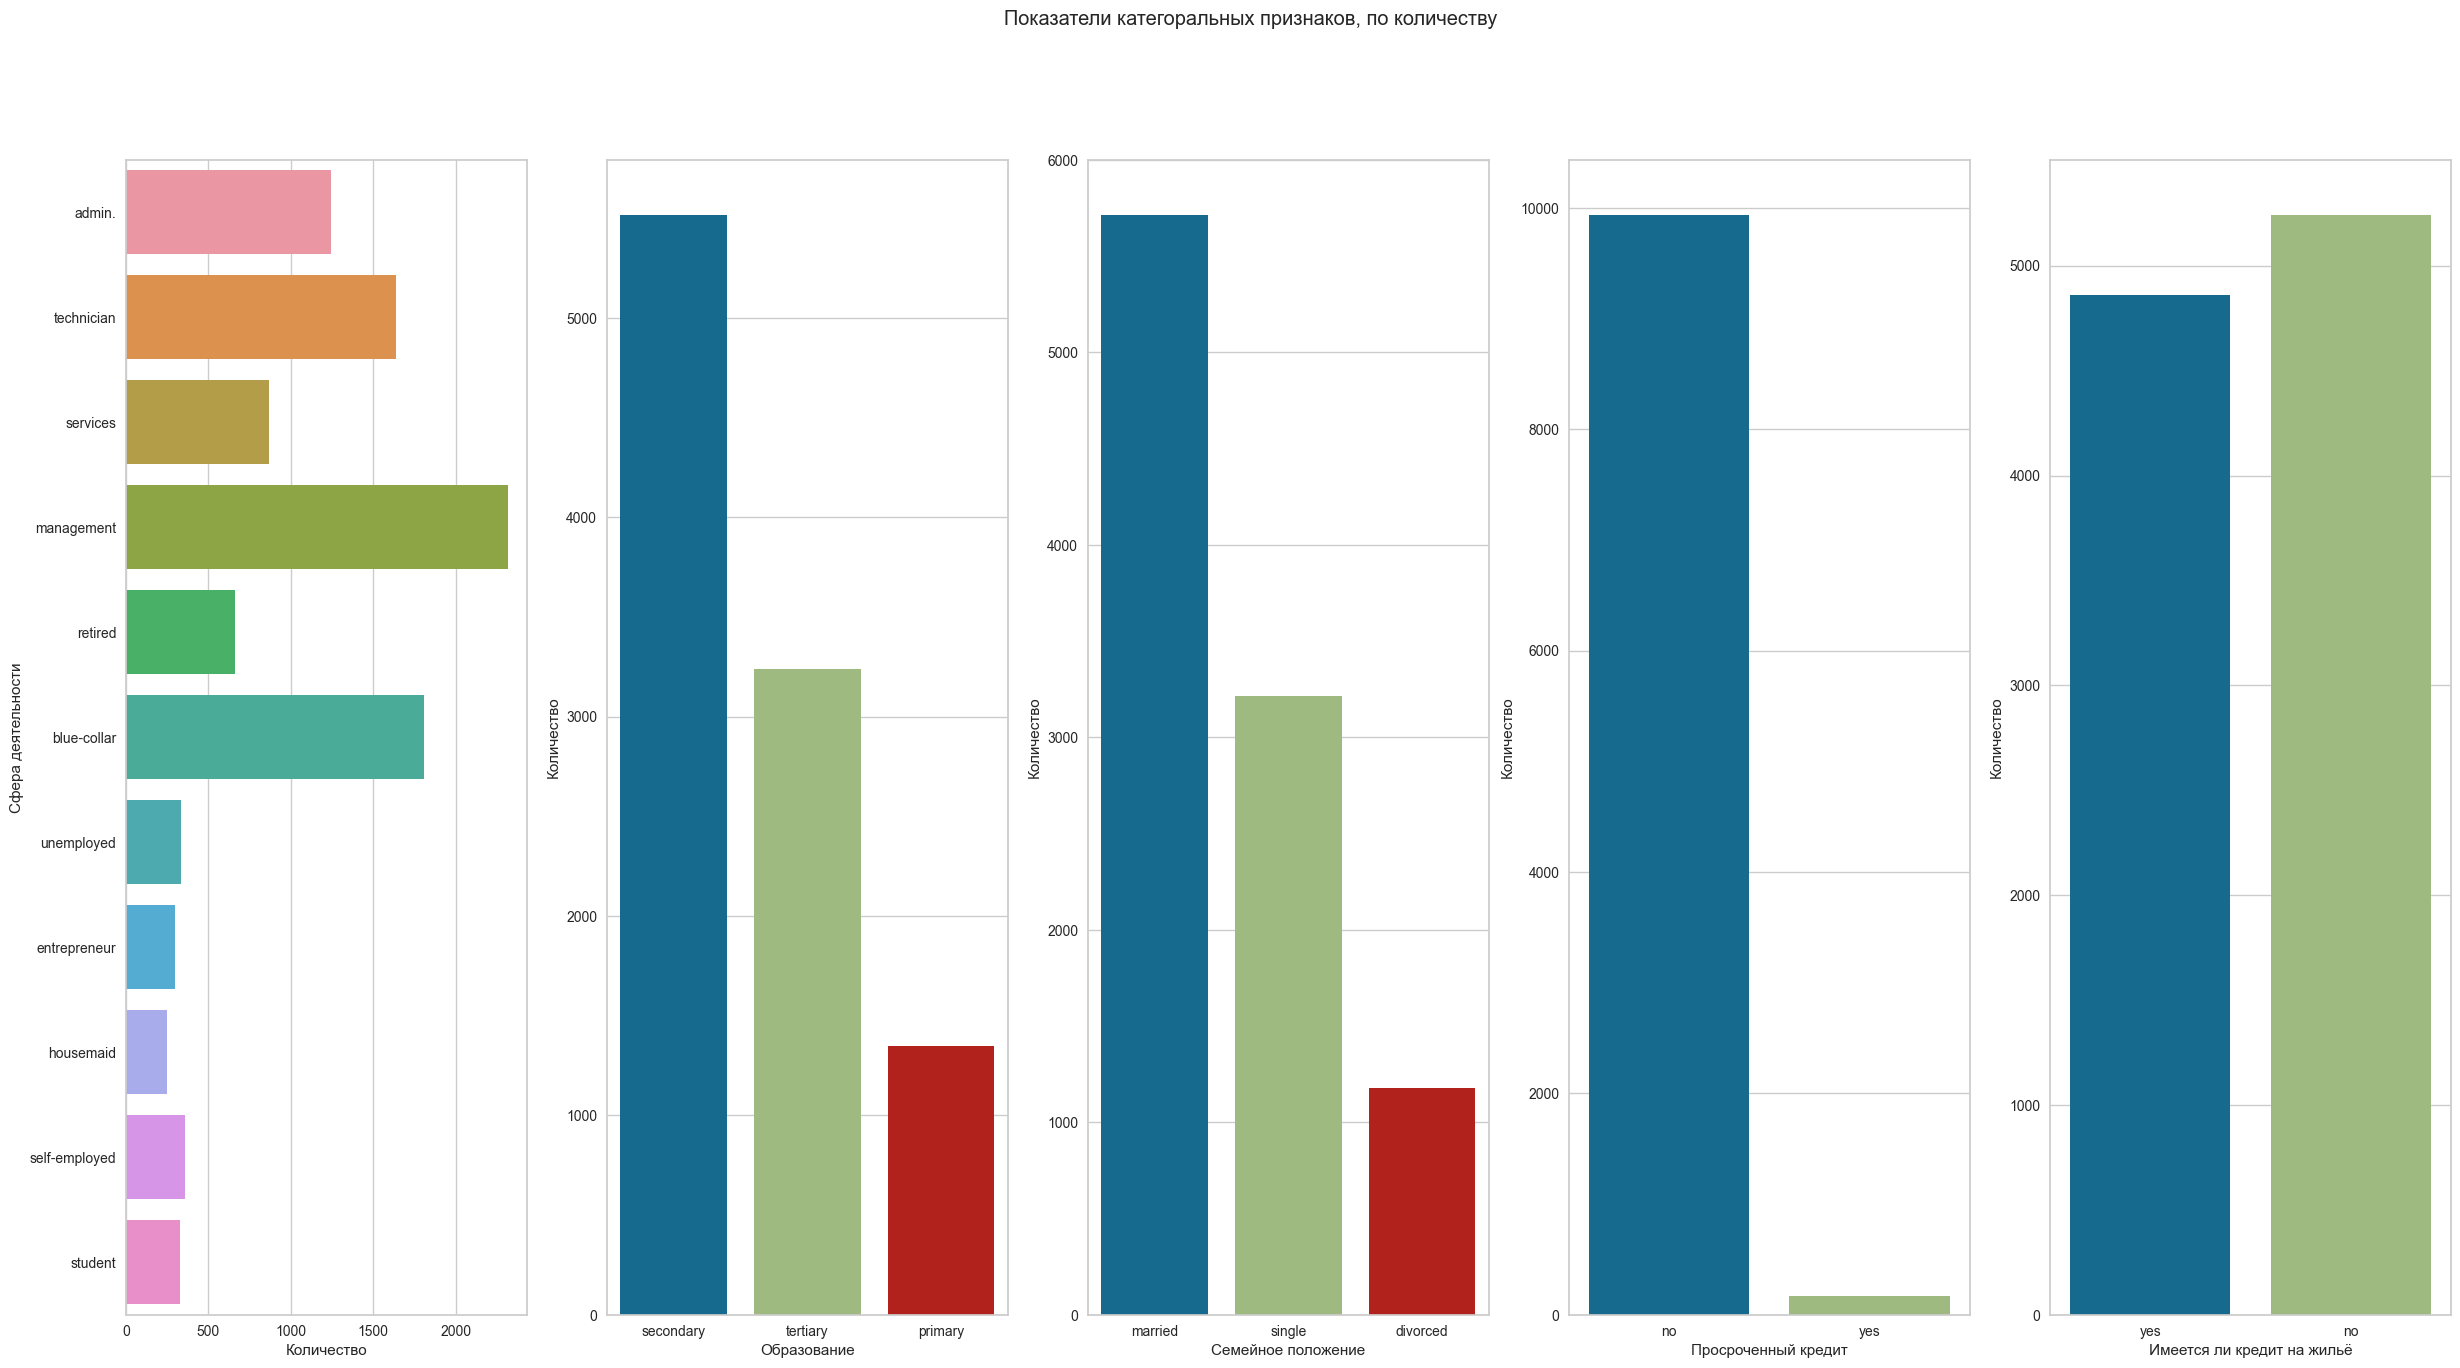

In [21]:
# создание графика с тремя диаграммами
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30,15))

# создание диаграммы для работы
sns.countplot(y='job', data=df, ax=axes[0])

# создание диаграммы для образования
sns.countplot(x='education', data=df, ax=axes[1])

# создание диаграммы для семейного положения
sns.countplot(x='marital', data=df, ax=axes[2])


sns.countplot(x='default', data=df, ax=axes[3])


sns.countplot(x='housing', data=df, ax=axes[4])


# настройка заголовка и меток осей
fig.suptitle('Показатели категоральных признаков, по количеству')
axes[0].set_xlabel('Количество')
axes[0].set_ylabel('Сфера деятельности')
axes[1].set_xlabel('Образование')
axes[1].set_ylabel('Количество')
axes[2].set_xlabel('Семейное положение')
axes[2].set_ylabel('Количество')
axes[3].set_xlabel('Просроченный кредит')
axes[3].set_ylabel('Количество')
axes[4].set_xlabel('Имеется ли кредит на жильё')
axes[4].set_ylabel('Количество')





# отображение графика
plt.show()

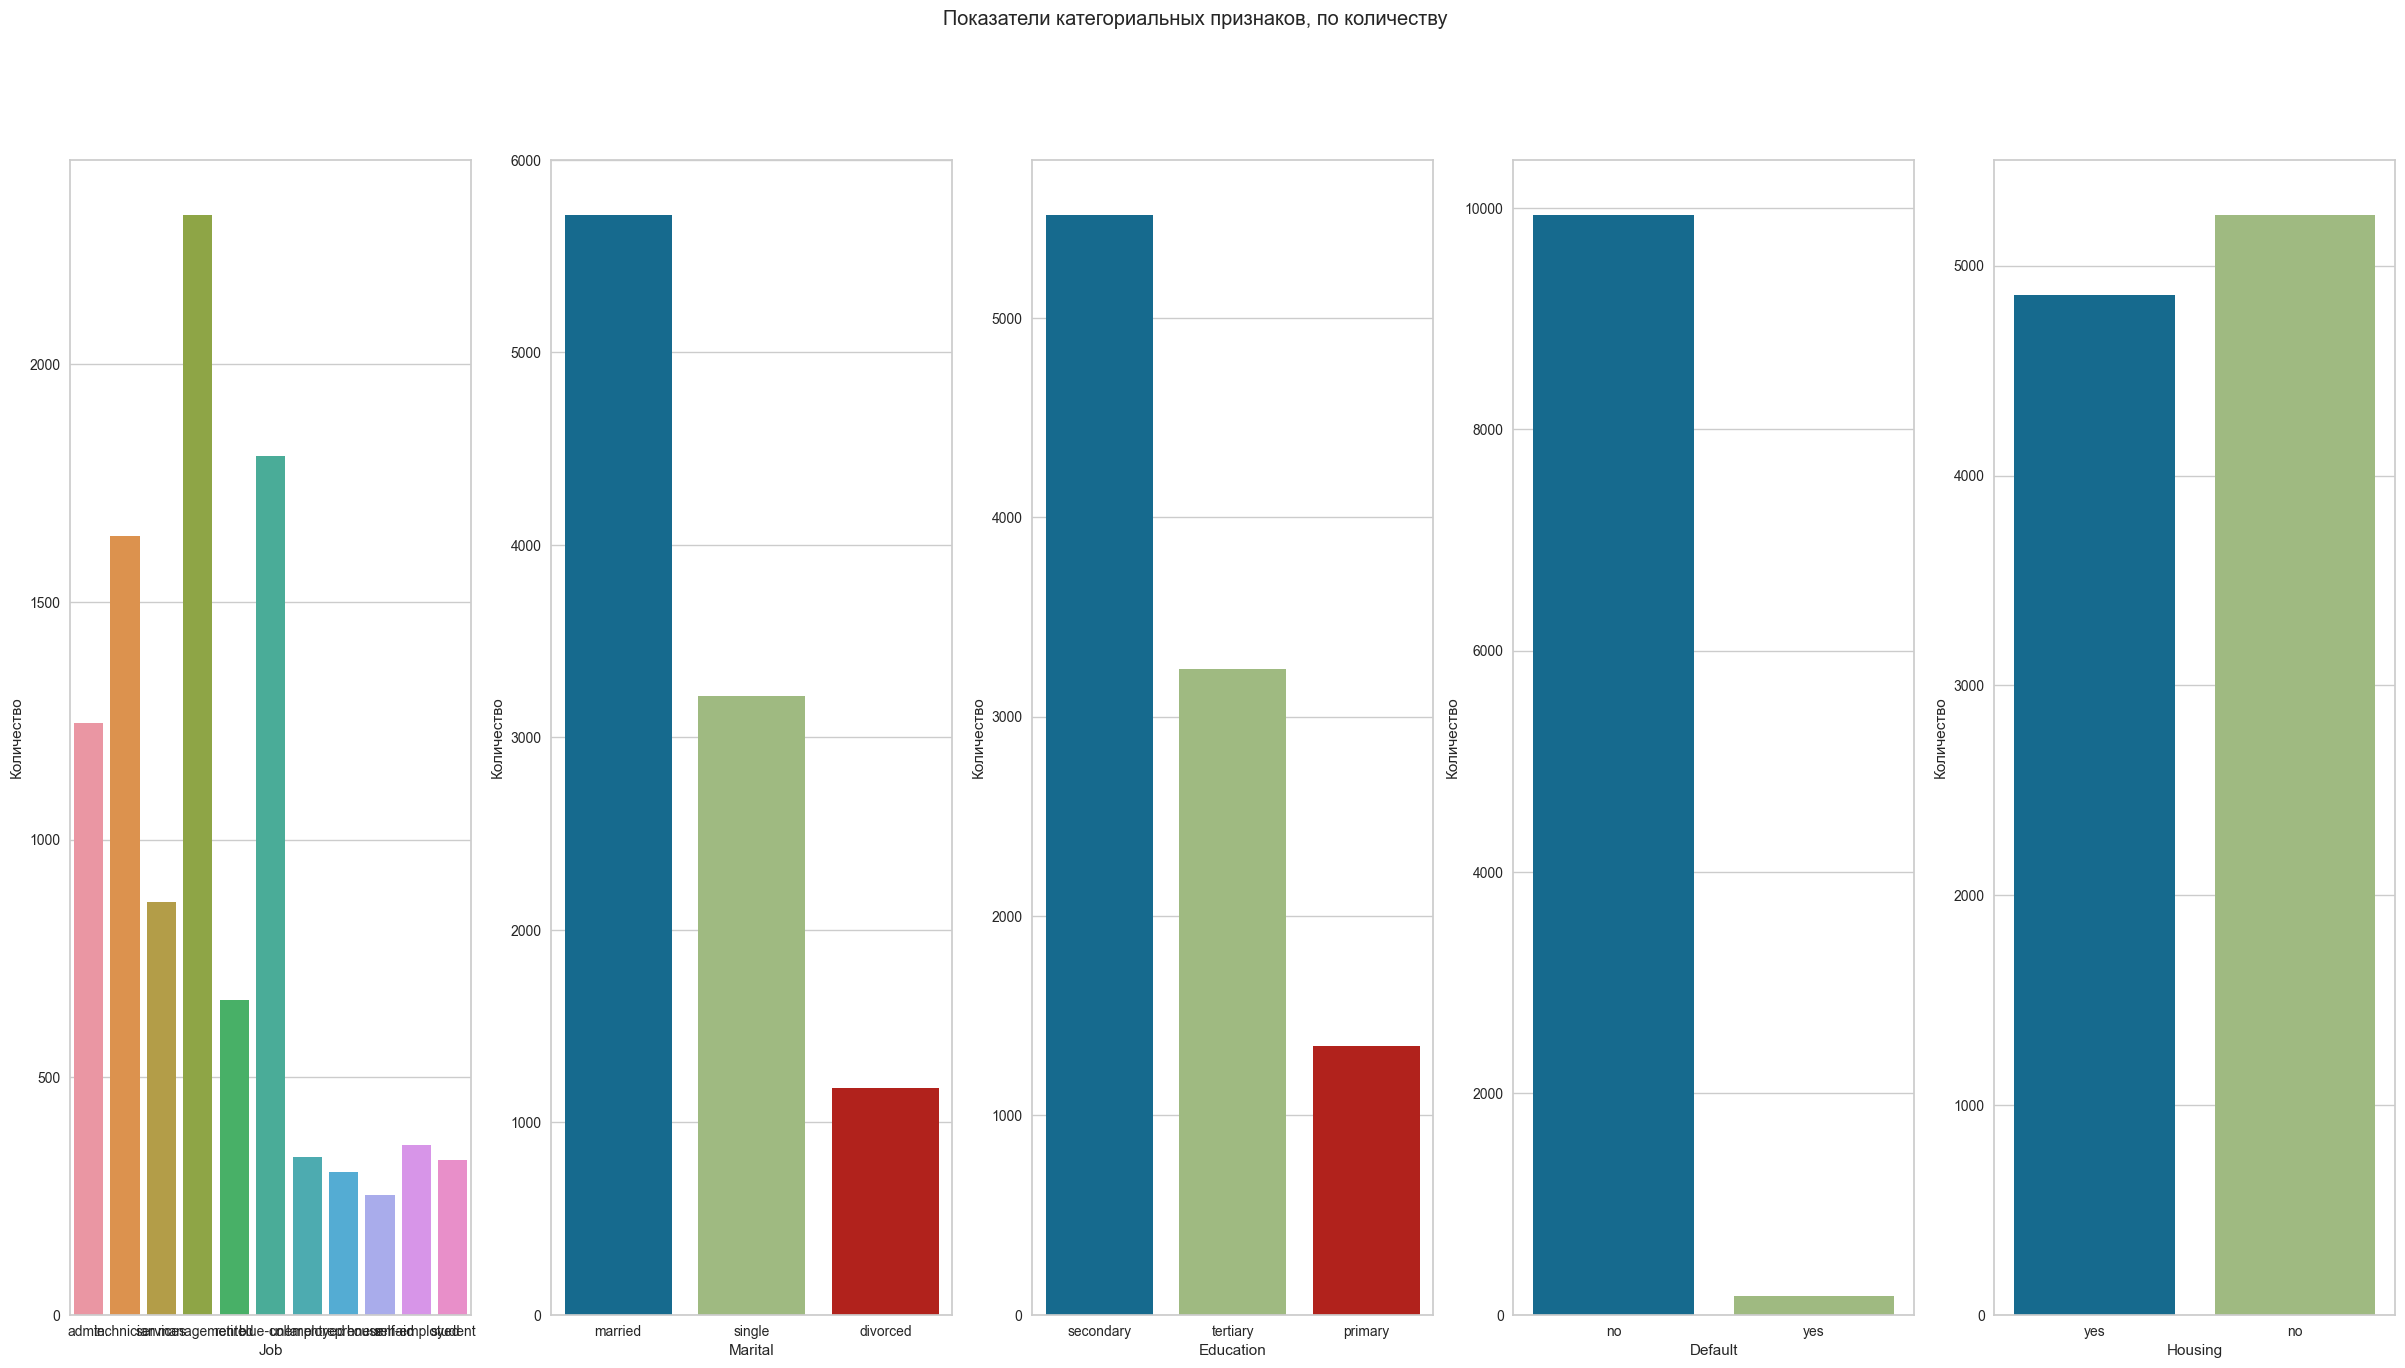

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30,15))

# список столбцов для построения диаграмм
cols = ['job', 'marital', 'education', 'default', 'housing']

# цикл для построения диаграмм
for i, col in enumerate(cols):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Количество')

# установка заголовка
fig.suptitle('Показатели категориальных признаков, по количеству')

# отображение графика
plt.show()

# более красивы график в ячейке выше

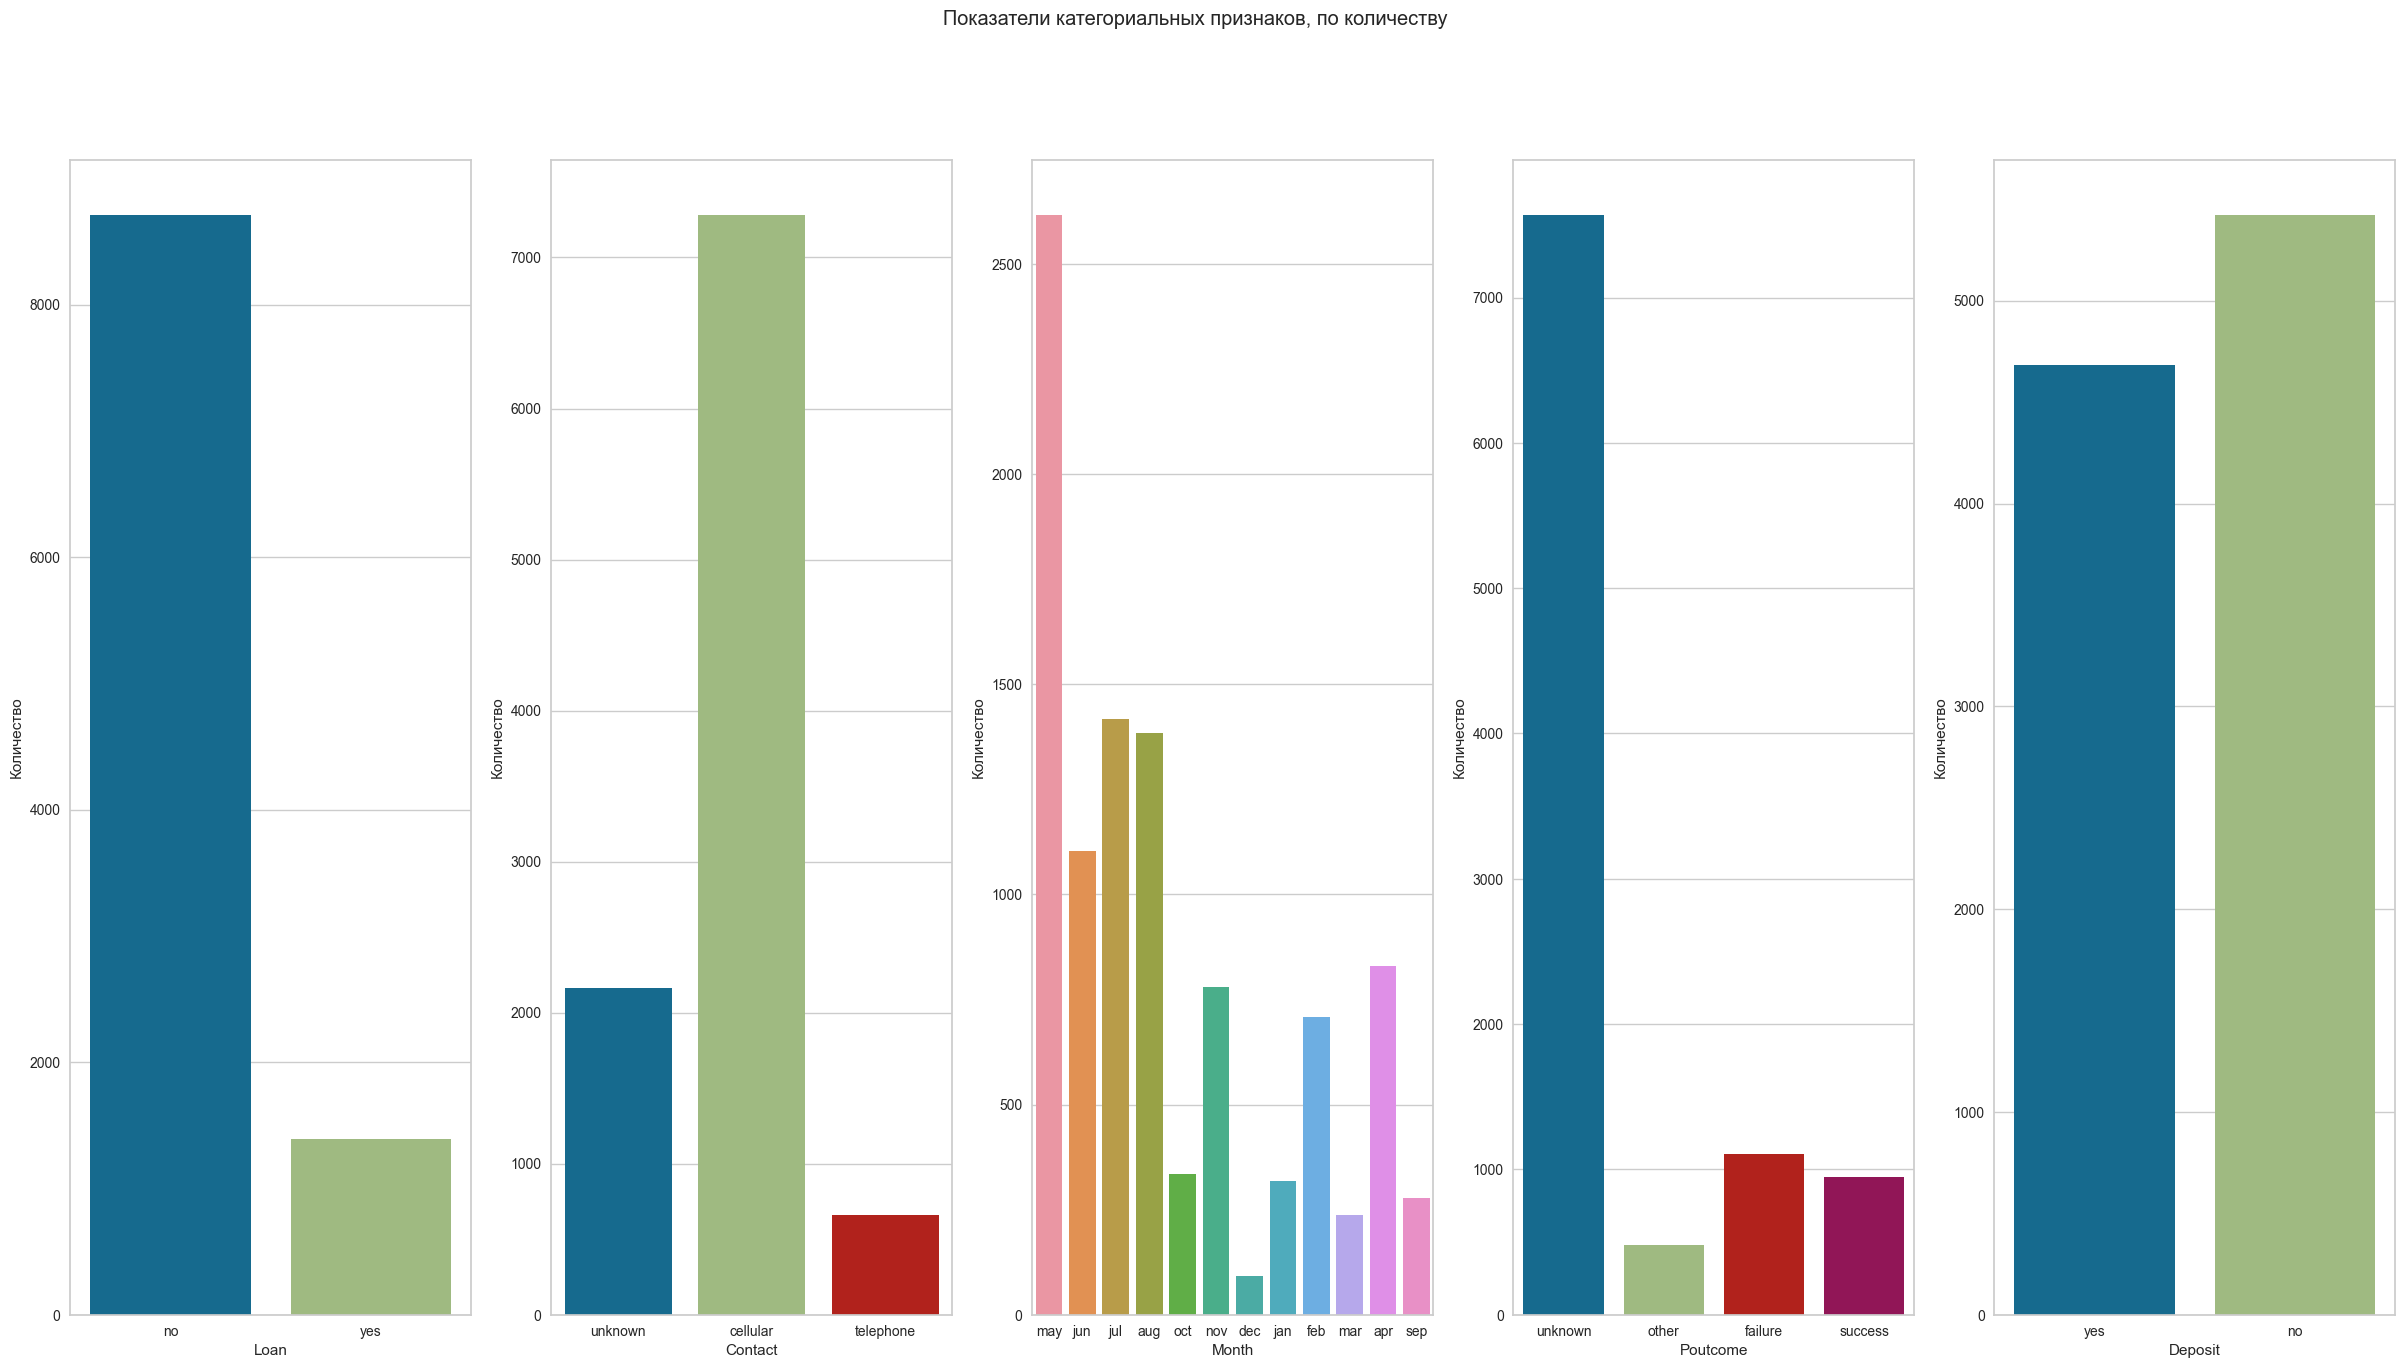

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30,15))

# список столбцов для построения диаграмм
cols = ['loan', 'contact', 'month', 'poutcome', 'deposit']

# цикл для построения диаграмм
for i, col in enumerate(cols):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Количество')

# установка заголовка
fig.suptitle('Показатели категориальных признаков, по количеству')

# отображение графика
plt.show()

Сколько было месяцев, в которых проводилась маркетинговая кампания?

In [24]:
df['month'].nunique()

12

Сколько сфер занятости представлено среди клиентов банка?


In [25]:
df['job'].nunique()

11

Теперь давайте узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

Напишите значение статуса предыдущей кампании, для которой в текущей успехов намного больше, чем неудач.

Если за успех взять открытие депозита, то можно предположить что сравнивать нужно будет положительный результат действуйющей кампании и прошедшей

In [26]:
df['poutcome'].value_counts()

poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64

In [27]:
df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

Теперь давайте узнаем, какова зависимость результата маркетинговых кампаний от месяца.

Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

Рассчитайте, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить. Введите название месяца латиницей ровно так, как месяц обозначен в данных.

In [28]:
df.groupby('month')['deposit'].value_counts()
# самое большое количество отрицательных значений в мае 

month  deposit
apr    yes         513
       no          317
aug    no          775
       yes         610
dec    yes          84
       no            9
feb    yes         386
       no          323
jan    no          194
       yes         125
jul    no          836
       yes         582
jun    no          606
       yes         498
mar    yes         213
       no           24
may    no         1776
       yes         841
nov    no          456
       yes         324
oct    yes         273
       no           62
sep    yes         232
       no           46
Name: count, dtype: int64

Нам бы очень хотелось посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.

Создайте новую переменную, в которой будет находиться индикатор принадлежности к одной из следующих категорий:

'<30';
'30-40';
'40-50';
'50-60';
'60+'.
Совет. После создания этой переменной постройте диаграмму (на ваш вкус), которая, с вашей точки зрения, сможет наилучшим образом отобразить различия в количестве открытых/не открытых депозитов для каждой возрастной группы.

In [29]:
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, float('inf')], labels=['<30', '30-40', '40-50', '50-60', '60+'])

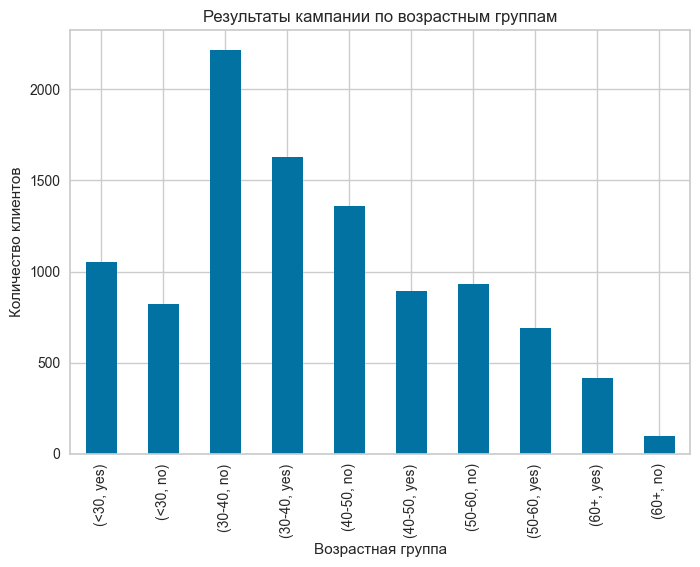

In [30]:
grouped = df.groupby('age_group')['deposit'].value_counts()
grouped.plot(kind='bar', stacked=True)

plt.title('Результаты кампании по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество клиентов')

plt.show()

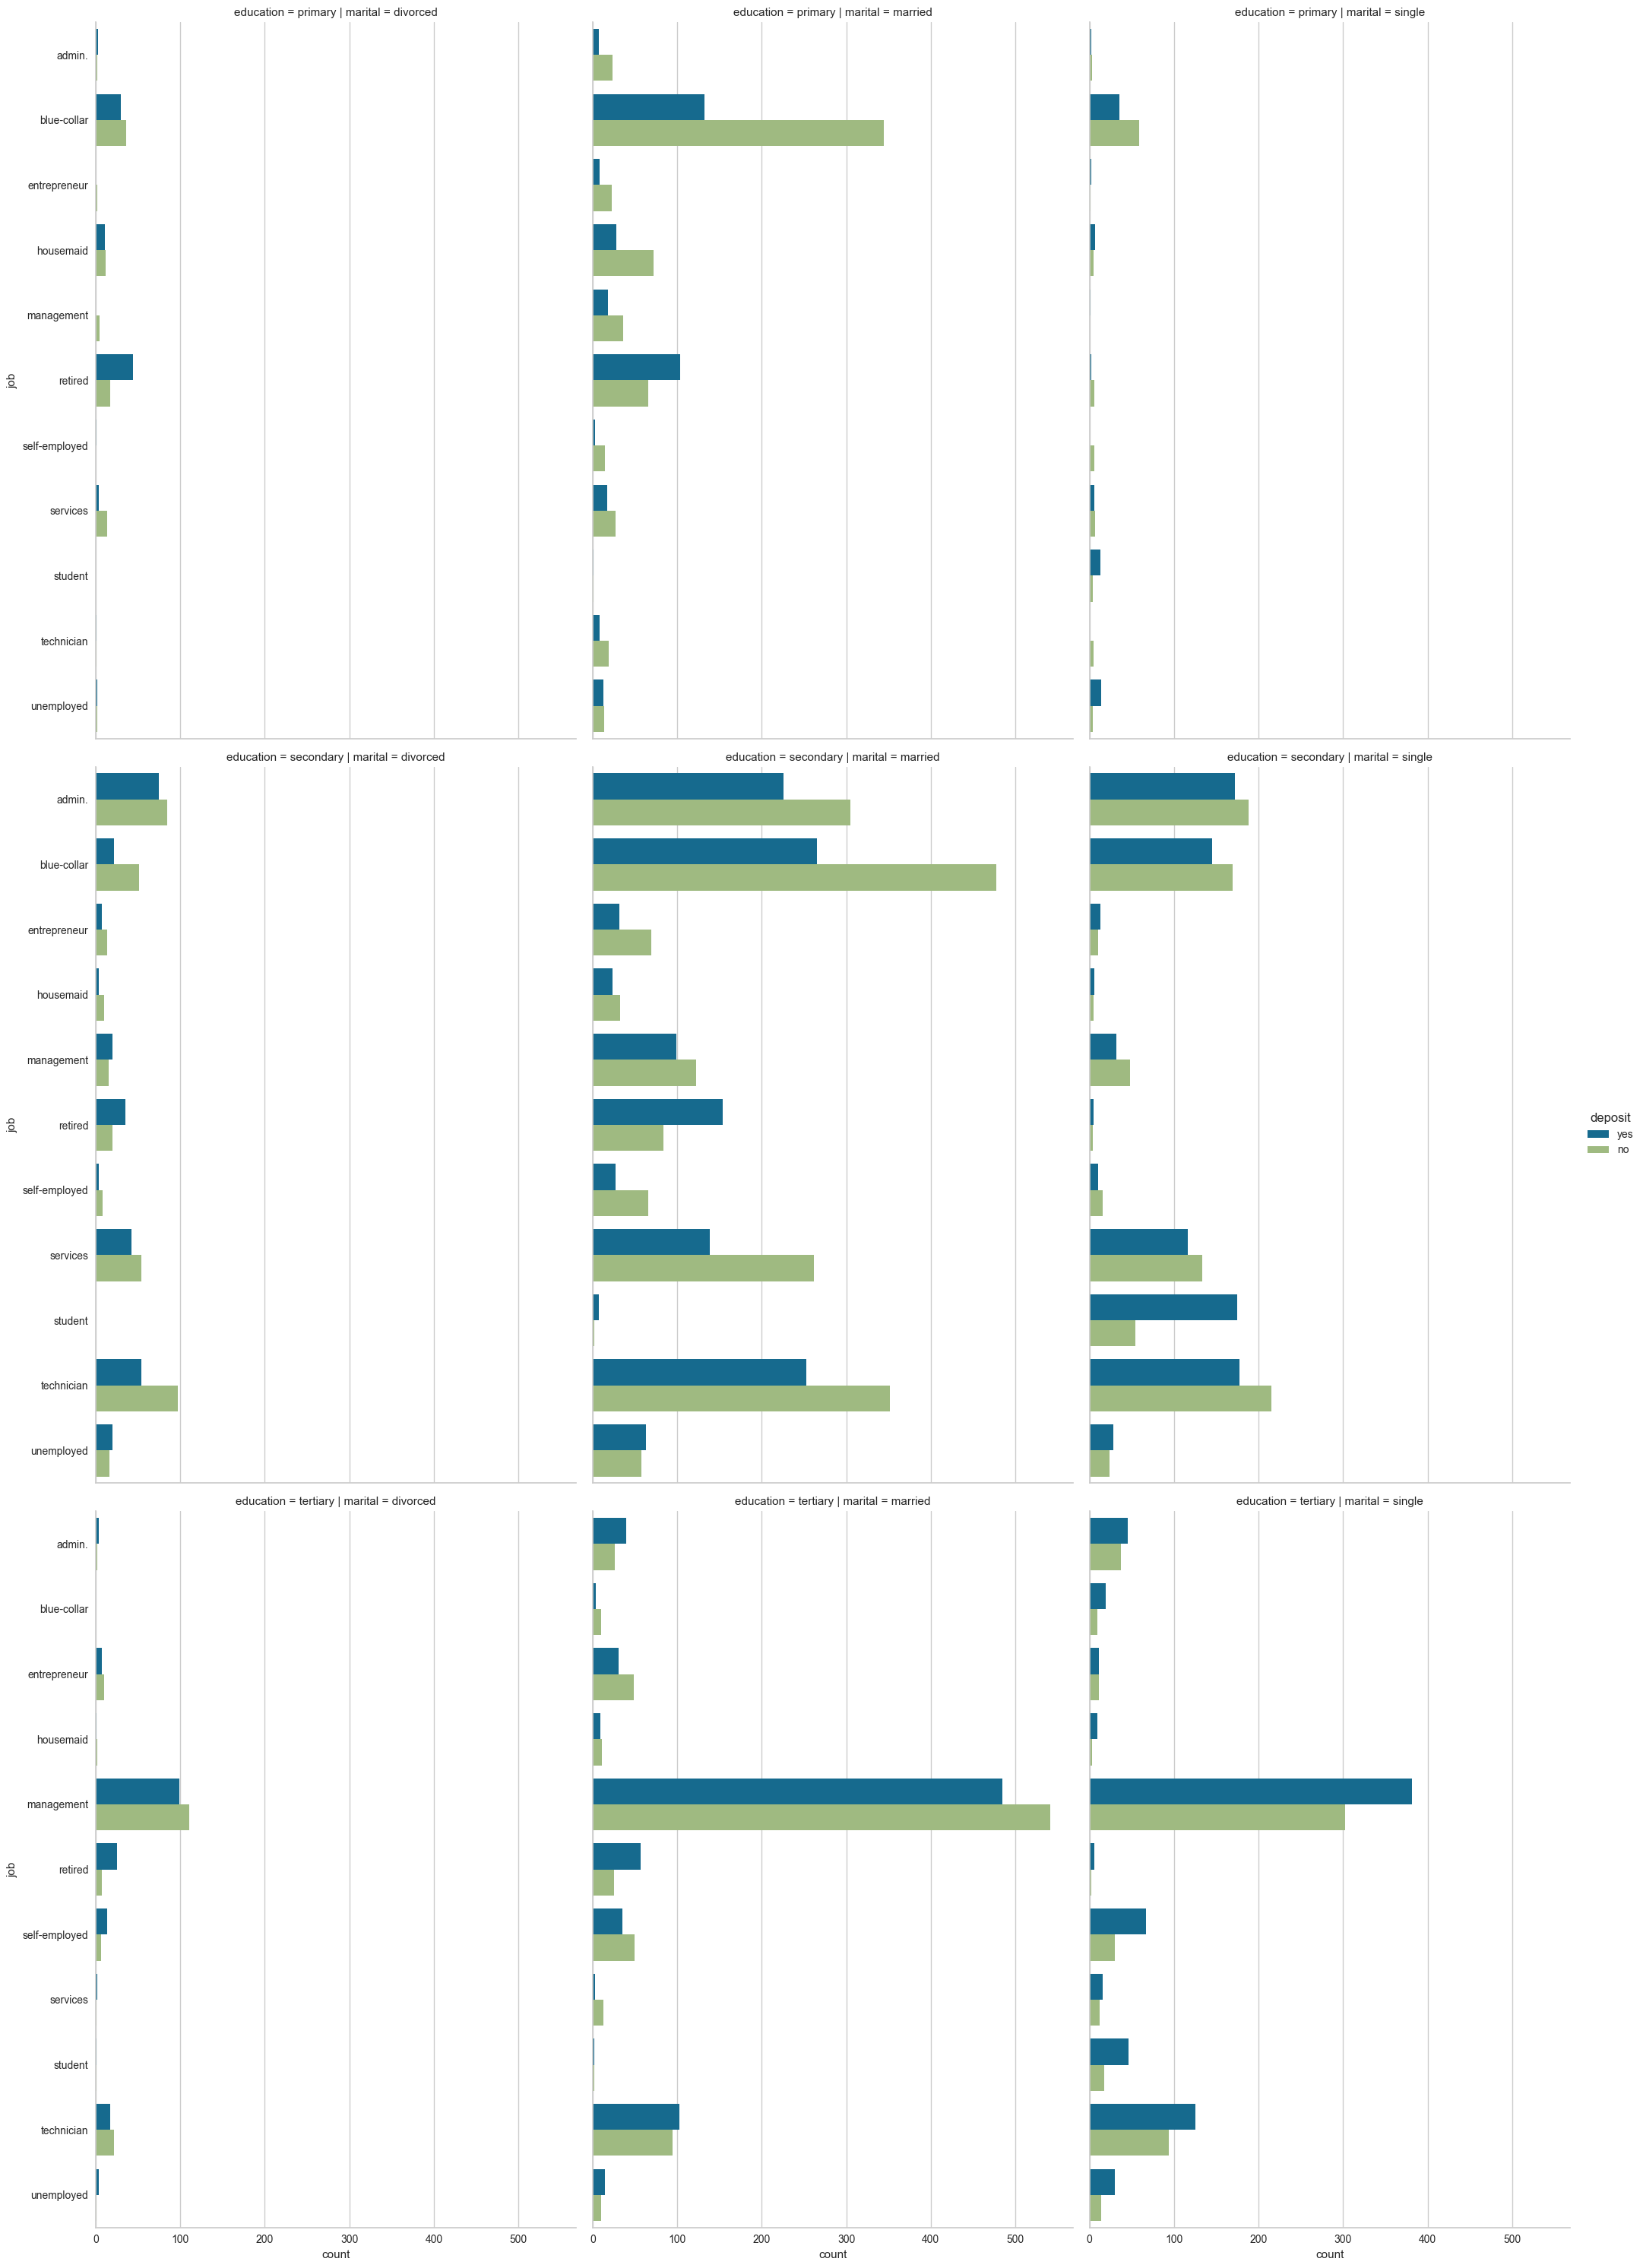

In [31]:
grouped_2 = df.groupby(['job', 'marital', 'education'])['deposit'].value_counts().reset_index(name='count')
grouped_2
sns.catplot(x='count', y='job', hue='deposit', col='marital', row='education', data=grouped_2, kind='bar', height=10, aspect=0.7)

# отображение диаграммы
plt.show()

В какой сфере занято наибольшее число клиентов банка?


In [32]:
print(f"наибольшее число клиентов занято в {df['job'].value_counts()[:1]}")

наибольшее число клиентов занято в job
management    2315
Name: count, dtype: int64


При каком семейном положении есть тенденция открывать депозит, а не отказываться от его открытия?

In [33]:
grouped_3 = df.groupby(['marital', 'deposit'])['deposit'].count()
grouped_3

marital   deposit
divorced  no          624
          yes         553
married   no         3303
          yes        2412
single    no         1497
          yes        1716
Name: deposit, dtype: int64

In [34]:
proportions = grouped_3.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
print(f'при семейном положении {proportions[4:6]}')

при семейном положении marital  marital  deposit
single   single   no         46.59197
                  yes        53.40803
Name: deposit, dtype: float64


In [35]:
df_yes = df[df['deposit'] == 'yes']
df_no = df[df['deposit'] == ' no']

Пересечение каких двух категорий является самым многочисленным?

In [36]:
pd.crosstab(index=[df_yes['job']], columns=[df_yes['marital'], df_yes['education']])


marital       divorced                    married                     single   
education      primary secondary tertiary primary secondary tertiary primary   
job                                                                            
admin.               3        75        4       7       226       40       2  \
blue-collar         30        22        0     132       265        4      35   
entrepreneur         0         7        7       8        32       31       2   
housemaid           11         4        1      28        24        9       7   
management           0        20       99      18        99      485       1   
retired             44        35       25     104       154       57       2   
self-employed        1         4       14       3        27       35       0   
services             4        42        2      17       139        3       6   
student              0         0        1       1         7        2      13   
technician           1        54       17       8       253      103       0   
unemployed           2        20        4      13        63       15      14   

marital                           
education     secondary tertiary  
job                               
admin.              172       45  
blue-collar         145       19  
entrepreneur         13       11  
housemaid             6        9  
management           32      381  
retired               5        6  
self-employed        10       67  
services            116       16  
student             175       46  
technician          177      125  
unemployed           28       30

Перед тем как перейти к построению модели, осталось сделать ещё один шаг.

Следует помнить, что алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. По ходу работы алгоритм считает показатели (например, средние значения), которые можно вычислить только для количественных признаков. Поэтому нам необходимо преобразовать категориальные признаки в более удобный формат.
Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить качество модели.
Надо отобрать признаки, которые мы будем использовать для обучения модели.
Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: education.

Обработайте его с помощью метода LabelEncoder, используя метод без дополнительных настроек. 

In [37]:
from sklearn.preprocessing import LabelEncoder

def label_encode_column(data, column_name):
    le = LabelEncoder()
    data[column_name] = le.fit_transform(data[column_name])

df_columns_to_encode = ["education", "age_group", "deposit", "default", "housing", "loan", "marital"]

for column_name in df_columns_to_encode:
    label_encode_column(df, column_name)

    



In [38]:
# def label_encode_column(df, column):
#     label_encoder = LabelEncoder()
#     df[column] = label_encoder.fit_transform(df[column])
#     print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


In [39]:
# label_encode_column(df, "education")
# label_encode_column(df, "age_group")
# label_encode_column(df, "deposit")
# label_encode_column(df, "default")
# label_encode_column(df, "housing")
# label_encode_column(df, "loan")
# label_encode_column(df, "marital")

In [40]:
round(df['deposit'].std(), 3)

0.499

In [41]:
round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(), 3)

0.635

Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:

'job';
'marital';
'contact';
'month';
'poutcome'.
Создайте для них dummy-переменные и добавьте их в набор данных.

In [42]:
import pandas as pd

def create_dummy_variables(df, column_name):
    """
    Функция принимает датафрейм df и название колонки column_name,
    и возвращает датафрейм с добавленными фиктивными переменными 
    для указанного категориального признака.
    """
    dummy_df = pd.get_dummies(df[column_name], prefix=column_name)
    return pd.concat([df, dummy_df.apply(lambda x: x.astype(int))], axis=1)


In [43]:
columns_to_dummy = ["job", "marital", "contact", "month", "poutcome"]
for column in columns_to_dummy:
    df = create_dummy_variables(df, column)


In [44]:
df_noobject = df.select_dtypes(exclude=['object'])

In [45]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,1,1,0,2343.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
1,56,admin.,1,1,0,45.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
2,41,technician,1,1,0,1270.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
3,55,services,1,1,0,2476.0,1,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
4,54,admin.,1,2,0,184.0,0,0,unknown,5,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,33,blue-collar,2,0,0,1.0,1,0,cellular,20,...,0,0,0,0,0,0,0,0,0,1
10101,39,services,1,1,0,733.0,0,0,unknown,16,...,1,0,0,0,0,0,0,0,0,1
10102,32,technician,2,1,0,29.0,0,0,cellular,19,...,0,0,0,0,0,0,0,0,0,1
10103,43,technician,1,1,0,0.0,0,1,cellular,8,...,0,0,1,0,0,0,1,0,0,0


Теперь давайте оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Для этого постройте матрицу корреляций. Дополните её тепловой картой, отражающей результат. Не забудьте, что для того, чтобы вычислить коэффициенты корреляции, необходимо, чтобы целевая переменная была числовой.

В качестве дополнения визуализации к этому заданию постройте столбчатую диаграмму для ранжированных коэффициентов корреляции.

Теперь давайте оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Для этого постройте матрицу корреляций. Дополните её тепловой картой, отражающей результат. Не забудьте, что для того, чтобы вычислить коэффициенты корреляции, необходимо, чтобы целевая переменная была числовой.

В качестве дополнения визуализации к этому заданию постройте столбчатую диаграмму для ранжированных коэффициентов корреляции.

<Axes: >

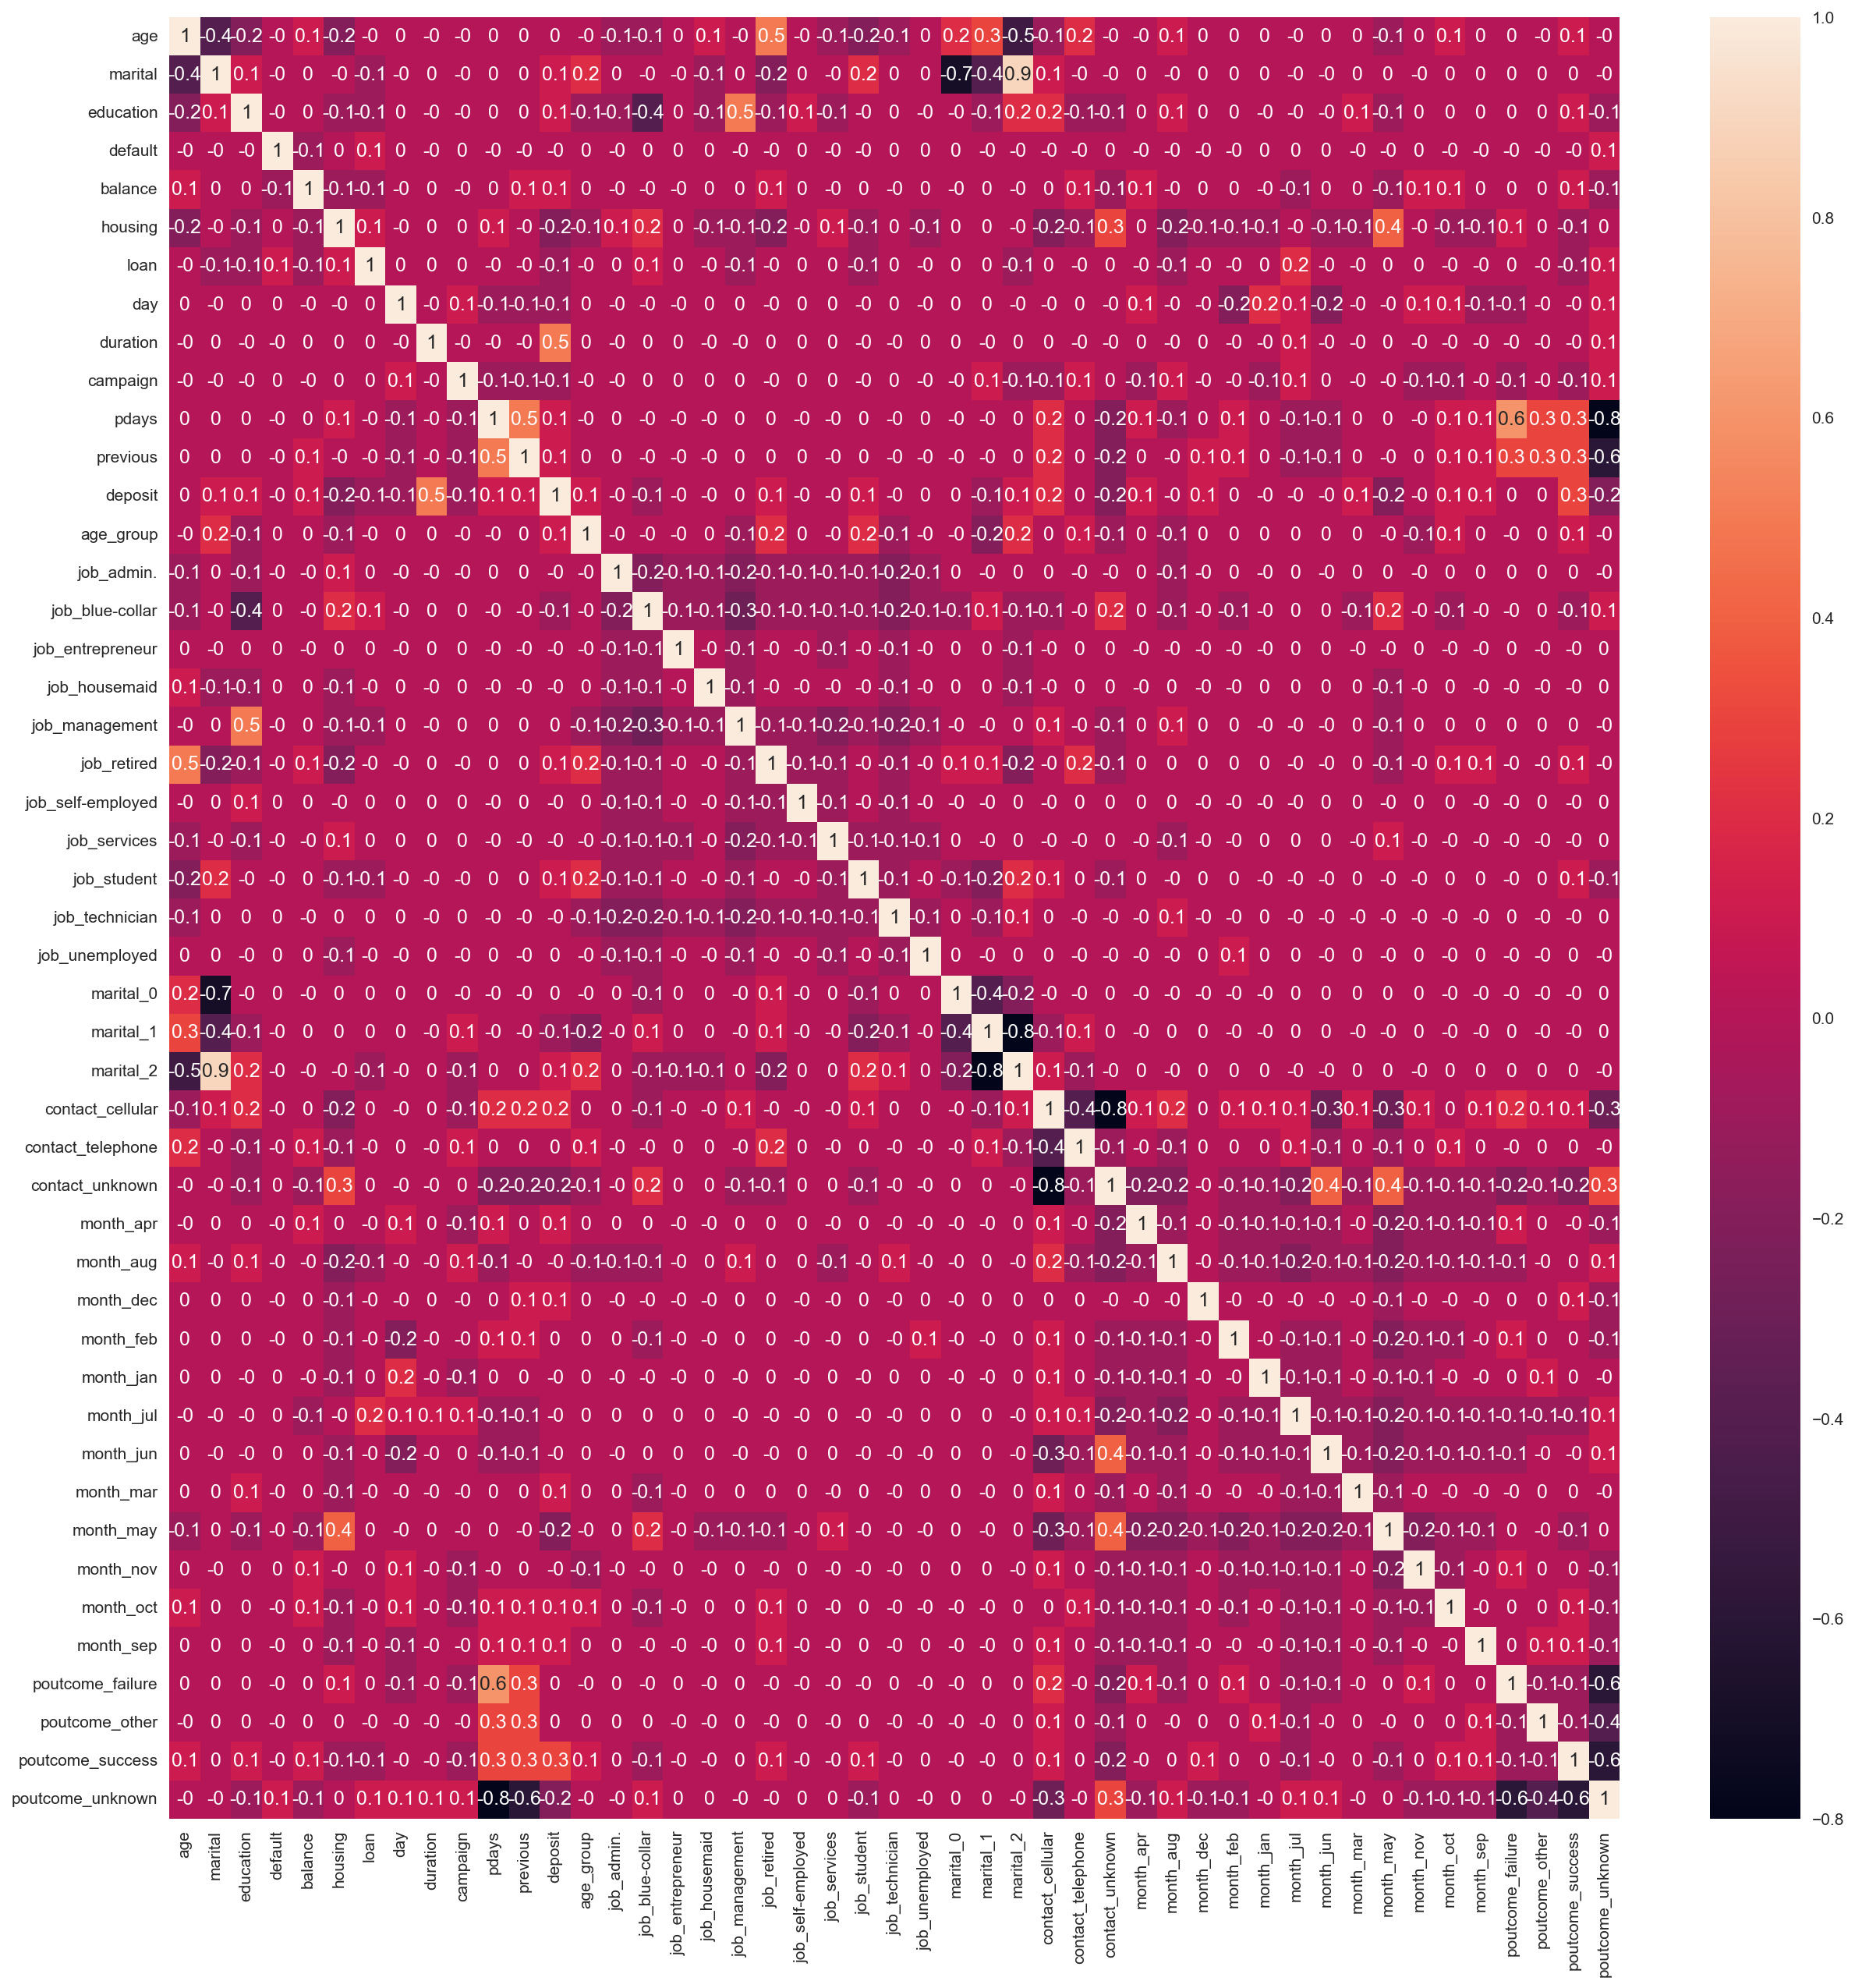

In [46]:
plt.figure(figsize=(20, 20), dpi=150)  # задаем размер фигуры и разрешение

sns.heatmap(round(df_noobject.corr(), 1), annot=True)



Теперь вам необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

При разбиении задайте параметр random_state = 42, а размер тестовой выборки возьмите за 0.33. Не забудьте добавить аргумент, определяющий сохранение соотношений целевого признака.



In [47]:
from sklearn.model_selection import train_test_split

X = df.drop('deposit', axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)


In [48]:
round(y_test.mean(), 2)

0.46

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберите 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_classif.

Помните, что на данном этапе вам необходимо оставить только те признаки, которые содержат лишь числовые значения.

НУЖНО ПЕРЕВЕСТИ ВСЕ ЗНАЧЕНИЯ БУЛ К ИНТУ

In [49]:
from sklearn.feature_selection import SelectKBest, f_classif

# Оставляем только числовые признаки в обучающей выборке
X_train_numeric = X_train.select_dtypes(include='number')

# Инициализируем объект SelectKBest и применяем его к обучающей выборке
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train_numeric, y_train)

# Отбираем 15 лучших признаков
best_features = X_train_numeric.columns[selector.get_support()]

# Выводим список лучших признаков
print(best_features)


Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


In [50]:
X_train_numeric[best_features]

,balance,housing,duration,campaign,pdays,previous,age_group,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
6542,557.0,1,513,1,-1,0,0,1,0,0,0,0,0,0,1
4230,69.0,0,296,1,205,2,0,1,0,0,0,0,0,0,0
5079,0.0,1,399,2,358,5,0,0,0,0,1,0,0,0,0
2265,444.0,0,137,1,102,5,0,1,0,0,0,0,0,1,0
8386,1444.0,0,100,1,117,8,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6627,222.0,0,111,1,204,2,4,1,0,0,0,0,0,0,0
954,1777.0,1,796,5,154,1,2,1,0,0,0,0,0,0,0
2590,3324.0,0,122,1,92,3,3,1,0,0,0,0,0,1,0
6955,209.0,0,605,2,-1,0,4,1,0,0,0,0,0,0,1


In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Нормализация обучающей выборки
X_train = scaler.fit_transform(X_train[best_features])

# Нормализация тестовой выборки
X_test = scaler.transform(X_test[best_features])


In [52]:
round(X_test[:, 0].mean(), 2)

0.47

Для начала реализуем самый простой алгоритм, который вам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

Оцените качество модели на тестовой выборке.

In [53]:
from sklearn.linear_model import LogisticRegression

# Создание модели логистической регрессии
logreg = LogisticRegression(solver='sag', random_state=42, max_iter=1000)

# Обучение модели на тренировочных данных
X_train_log = logreg.fit(X_train, y_train)


In [54]:
from sklearn.metrics import accuracy_score

# Получаем предсказания модели для тестовой выборки
y_pred = X_train_log.predict(X_test)

# Оцениваем качество модели на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", round(accuracy, 2))


Accuracy on test set: 0.81


Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:

criterion = 'entropy';
random_state = 42.
Остальные параметры оставьте по умолчанию.

In [55]:
from sklearn.tree import DecisionTreeClassifier

# Создаем объект класса DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Обучаем модель на тренировочных данных
tree.fit(X_train, y_train)

# Получаем предсказания на тестовых данных
y_pred = tree.predict(X_test)

train_score = tree.score(X_train, y_train)
print('Train score:', train_score)

test_score = tree.score(X_test, y_test)
print('Test score:', round(test_score, 2))

# Вычисляем accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 2))


Train score: 1.0
Test score: 0.75
Accuracy: 0.75


ПЕРЕОБУЧЕНА модель

Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
import numpy as np

max_depths = range(1, 21)
train_scores = []
val_scores = []

for depth in max_depths:
    # Создаем объект класса DecisionTreeClassifier
    tree = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=depth)

    # Вычисляем accuracy на тренировочных и валидационных данных с помощью кросс-валидации
    scores = cross_validate(tree, X_train, y_train, cv=5, return_train_score=True)
    train_scores.append(scores['train_score'].mean())
    val_scores.append(scores['test_score'].mean())

    print('Max depth:', depth)
    print('Train score:', round(train_scores[-1], 2))
    print('Validation score:', round(val_scores[-1], 2))

# Находим индекс максимальной accuracy на валидации
best_val_score_index = np.argmax(val_scores)

# Выводим оптимальное значение максимальной глубины дерева
print('Best max depth:', max_depths[best_val_score_index])


Max depth: 1
Train score: 0.72
Validation score: 0.72
Max depth: 2
Train score: 0.76
Validation score: 0.76
Max depth: 3
Train score: 0.78
Validation score: 0.78
Max depth: 4
Train score: 0.78
Validation score: 0.78
Max depth: 5
Train score: 0.8
Validation score: 0.79
Max depth: 6
Train score: 0.82
Validation score: 0.81
Max depth: 7
Train score: 0.84
Validation score: 0.81
Max depth: 8
Train score: 0.85
Validation score: 0.81
Max depth: 9
Train score: 0.86
Validation score: 0.82
Max depth: 10
Train score: 0.87
Validation score: 0.81
Max depth: 11
Train score: 0.88
Validation score: 0.8
Max depth: 12
Train score: 0.89
Validation score: 0.8
Max depth: 13
Train score: 0.9
Validation score: 0.8
Max depth: 14
Train score: 0.92
Validation score: 0.79
Max depth: 15
Train score: 0.93
Validation score: 0.79
Max depth: 16
Train score: 0.94
Validation score: 0.78
Max depth: 17
Train score: 0.95
Validation score: 0.78
Max depth: 18
Train score: 0.96
Validation score: 0.78
Max depth: 19
Train scor

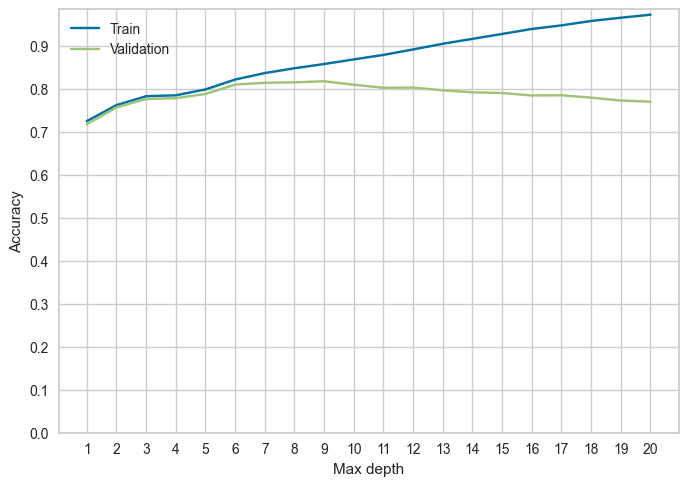

In [57]:
import matplotlib.pyplot as plt

# Строим график зависимости accuracy на тренировочной и валидационной выборках от максимальной глубины дерева
plt.plot(max_depths, train_scores, label='Train')
plt.plot(max_depths, val_scores, label='Validation')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(1, 21, 1))
plt.legend()
plt.show()



Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Реализуйте оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:

'min_samples_split': [2, 5, 7, 10];
'max_depth':[3,5,7].

Оцените метрику  на тестовой выборке для наилучшей комбинации перебираемых параметров. В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Определяем значения параметра, которые будем перебирать
param_grid = {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3, 5, 6, 7]}

# Создаем объект класса DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Инициализируем объект GridSearchCV
grid_search = GridSearchCV(tree, param_grid, cv=5)

# Обучаем GridSearchCV на тренировочных данных
grid_search.fit(X_train, y_train)

# Выводим наилучшее значение параметра
print('Best parament', grid_search.best_params_)


Best parament {'max_depth': 7, 'min_samples_split': 10}


In [59]:
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Определяем пространство поиска для параметров
param_grid = {
    'max_depth':[3,5,7],
    'min_samples_split': [2, 5, 7, 10],
}

# Создаем объект класса GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

# Обучаем модель на обучающей выборке с помощью GridSearchCV
grid_search.fit(X_train, y_train)

# Получаем наилучшие параметры и модель с этими параметрами
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Применяем модель к тестовой выборке и оцениваем f-метрику
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')

print("Best parameters: ", best_params)
print("F1 score on test set: ", round(f1, 2))


Best parameters:  {'max_depth': 7, 'min_samples_split': 2}
F1 score on test set:  0.81


 Вы уже смогли обучить несложные модели, и теперь пришло время усложнить их, а также посмотреть, улучшится ли результат (если да, то насколько). Вы обучили решающие деревья, и теперь пришла пора объединить их в случайный лес.

Обучите случайный лес со следующими параметрами:

n_estimators = 100;
criterion = 'gini';
min_samples_leaf = 5;
max_depth = 10;
random_state = 42.

In [60]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=5, max_depth=10, random_state=42)


In [61]:
rfc.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [62]:
y_pred_rfc = rfc.predict(X_test)


In [63]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rfc))


              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Градиентный бустинг

In [64]:
from sklearn.ensemble import GradientBoostingClassifier

# Создаем объект класса GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42)

# Обучаем модель на тренировочных данных
gb_clf.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42)

In [65]:
y_pred = gb_clf.predict(X_test)

In [66]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [67]:
from mlxtend.classifier import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Создаем базовые модели
dtc = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=7)
lr = LogisticRegression(solver='sag', random_state=42, max_iter=1000)
gbc = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42)

# Создаем метамодель
meta = LogisticRegression(solver='sag', random_state=42, max_iter=1000)

# Создаем объект стекинга
stack = StackingClassifier(classifiers=[dtc, lr, gbc], meta_classifier=meta)


In [68]:
stack.fit(X_train, y_train)


StackingClassifier(classifiers=[DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       random_state=42),
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag'),
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42)],
                   meta_classifier=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='sag'))

In [69]:
from sklearn.metrics import accuracy_score

y_pred = stack.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', round(accuracy, 2))


Accuracy: 0.83


Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

Почему, с вашей точки зрения, именно эти три признака имеют наибольшую важность?

In [83]:
from sklearn.model_selection import train_test_split

X = df.drop('deposit', axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [84]:
from sklearn.feature_selection import SelectKBest, f_classif

# Оставляем только числовые признаки в обучающей выборке
X_train_numeric = X_train.select_dtypes(include='number')

# Инициализируем объект SelectKBest и применяем его к обучающей выборке
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train_numeric, y_train)

# Отбираем 15 лучших признаков
best_features = X_train_numeric.columns[selector.get_support()]

# Выводим список лучших признаков
print(best_features)

Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


In [72]:
# df_clon = X_train_numeric[best_features_3]
# df_clon

In [73]:
# X = df_clon.drop('duration', axis=1)
# y = df_clon['duration']

In [91]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Нормализация обучающей выборки
X_train = scaler.fit_transform(X_train[best_features])

# Нормализация тестовой выборки
X_test = scaler.transform(X_test[best_features])


In [96]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# Разбиваем данные на тренировочную и тестовую выборки
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Определяем гиперпараметры для перебора
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Создаем модель случайного леса с заданными гиперпараметрами
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

    # Обучаем модель
    clf.fit(X_train, y_train)

    # Предсказываем значения на тестовой выборке
    y_pred = clf.predict(X_test)

    # Вычисляем accuracy на тестовой выборке
    score = accuracy_score(y_test, y_pred)

    return score

# Создаем объект study для оптимизации
study = optuna.create_study(direction='maximize')

# Запускаем оптимизацию гиперпараметров
study.optimize(objective, n_trials=100)

# Выводим оптимальное значение гиперпараметров и соответствующую accuracy
print('Best trial:')
trial = study.best_trial
print('  Value: {:.2f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, round(value, 2)))


[I 2023-05-21 16:24:02,940] A new study created in memory with name: no-name-7b74cfe9-d0bc-473b-b6dd-b42d67e41d3f
[I 2023-05-21 16:24:03,533] Trial 0 finished with value: 0.8248391885205344 and parameters: {'n_estimators': 160, 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8248391885205344.
[I 2023-05-21 16:24:03,946] Trial 1 finished with value: 0.8268184067293419 and parameters: {'n_estimators': 109, 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8268184067293419.
[I 2023-05-21 16:24:04,329] Trial 2 finished with value: 0.8258287976249381 and parameters: {'n_estimators': 121, 'max_depth': 17, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8268184067293419.
[I 2023-05-21 16:24:04,997] Trial 3 finished with value: 0.830776843146957 and parameters: {'n_estimators': 190, 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.830776843146957.
[I 2023-05-21 16:24:05,301] Trial 4 finished with value: 0.8233547748639287 

Best trial:
  Value: 0.83
  Params: 
    n_estimators: 131
    max_depth: 29
    min_samples_leaf: 6


In [98]:
from sklearn.metrics import accuracy_score


clf = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=5, max_depth=10, random_state=42)

clf.fit(X_train, y_train)


# Предсказываем значения на тестовой выборке
y_pred = clf.predict(X_test)

# Вычисляем accuracy на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)

# Выводим значение accuracy округленное до двух знаков после точки-разделителя
print('Accuracy on test set: {:.2f}'.format(accuracy))

Accuracy on test set: 0.82
